# # 모듈 및 함수
---

In [2]:
%pip list

Package                      Version              Editable project location
---------------------------- -------------------- -------------------------
absl-py                      1.4.0
addict                       2.4.0
appdirs                      1.4.4
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        22.2.0
autocommand                  2.2.2
backcall                     0.2.0
blis                         0.7.9
cachetools                   5.3.0
catalogue                    2.0.8
ccimport                     0.4.2
certifi                      2022.12.7
charset-normalizer           3.0.1
cheroot                      9.0.0
CherryPy                     18.8.0
click                        8.1.3
comm                         0.1.2
confection                   0.0.4
ConfigArgParse               1.5.3
contourpy                    1.0.7
cumm-cu114                   0.4.7
cycler                       0.11.0
cymem                        2.0.7
d

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
plt.style.use('dark_background')

ModuleNotFoundError: No module named 'cv2'

# # Crop carplate
---

## # Read Input Image
---

80 102 3


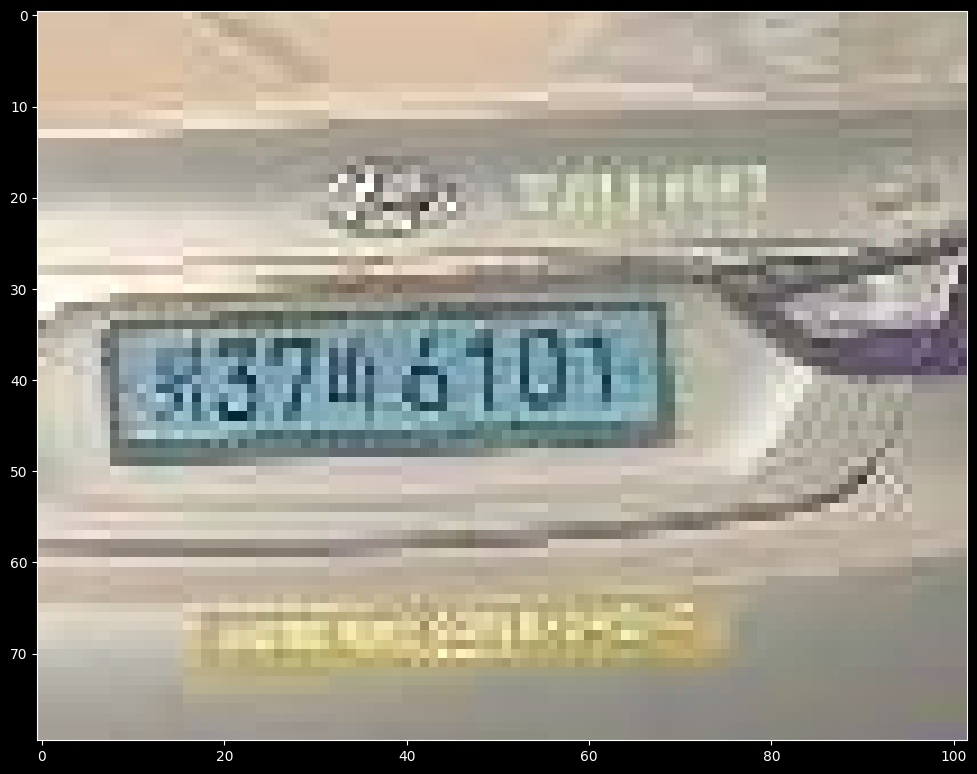

In [104]:
img_ori = cv2.imread('/data/kimgh/kakao/data/carplate/경기37바6101-6.jpg')
# img_ori = cv2.imread('/data/kimgh/kakao/data/carplate/충북80배1647-2.jpg')


height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')
print(height, width, channel)

## # Convert Image to Grayscale
---

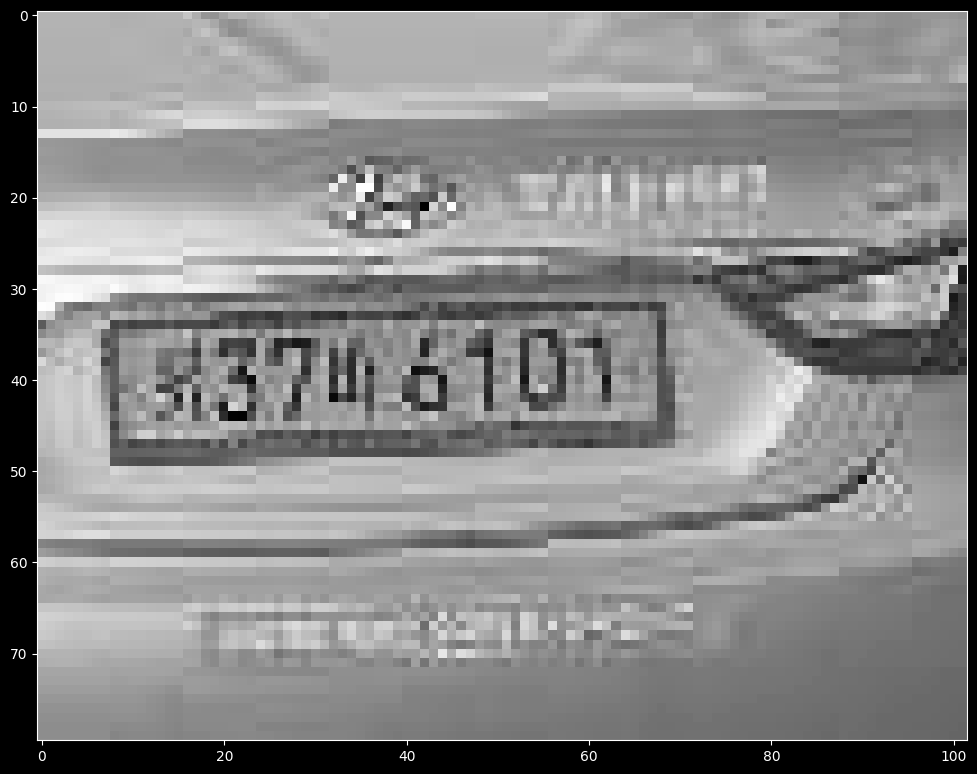

In [105]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:, :, 2]
# plt.figure(figsize=(12,10))
# plt.imshow(gray, cmap='gray')

## # Adaptive Thresholding
---
- 번호판 식별

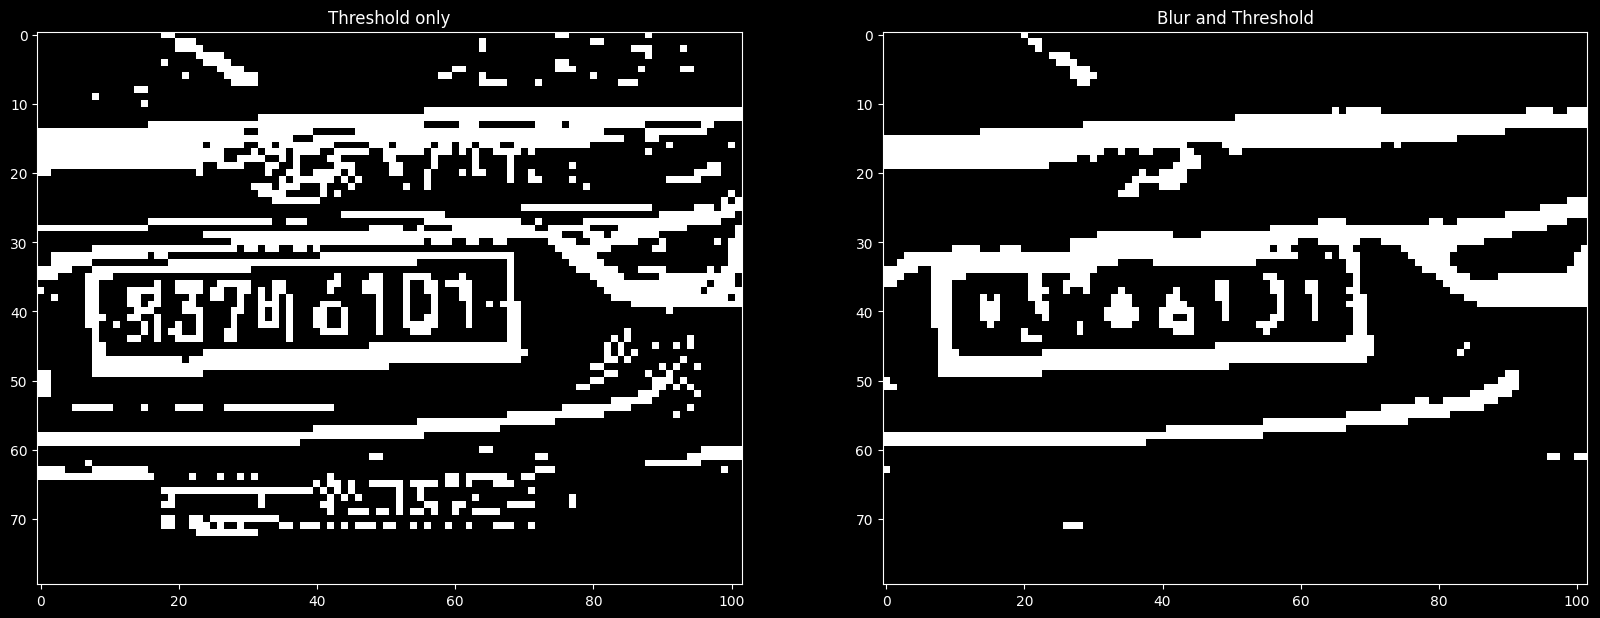

In [106]:
# 가우시안 블러 적용
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
    )

# 가우시안 블러 비적용
img_thresh = cv2.adaptiveThreshold(
    gray,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
    )

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Threshold only')
plt.imshow(img_thresh, cmap='gray')
plt.subplot(1,2,2)
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh, cmap='gray')

## # Find Contours
---
- Contours : 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선

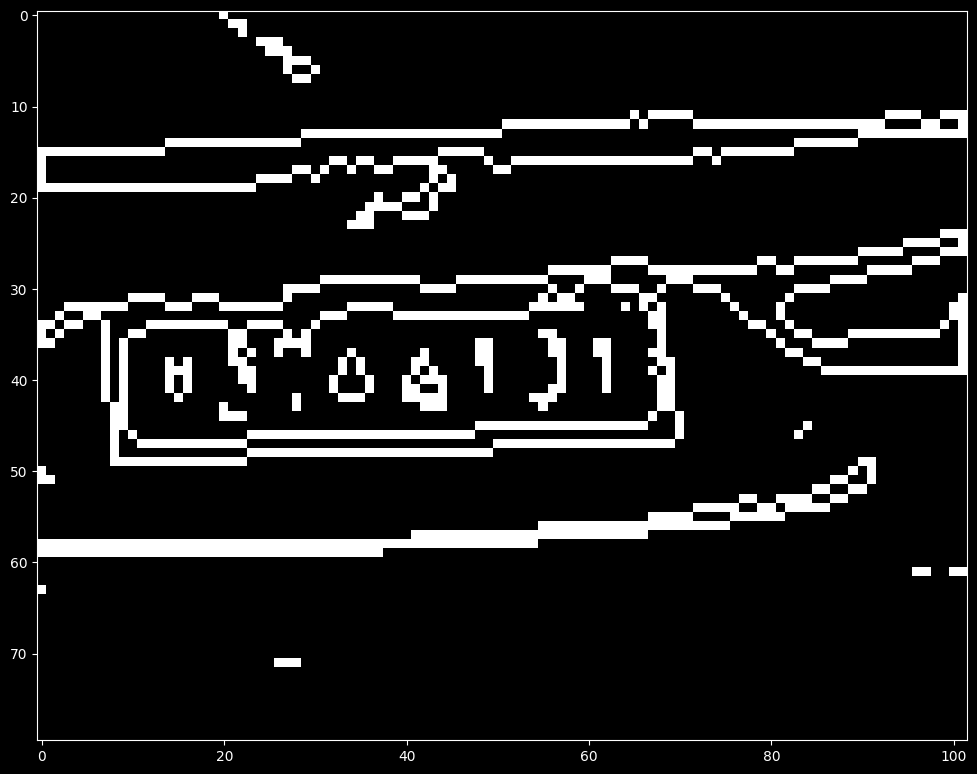

In [107]:
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

# contours, _ = cv2.findContours(
#     img_thresh,
#     mode=cv2.RETR_LIST,
#     method=cv2.CHAIN_APPROX_SIMPLE
# )

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

## # Prepare Data
---
- contours의 좌표를 이용해 사각형 그리기

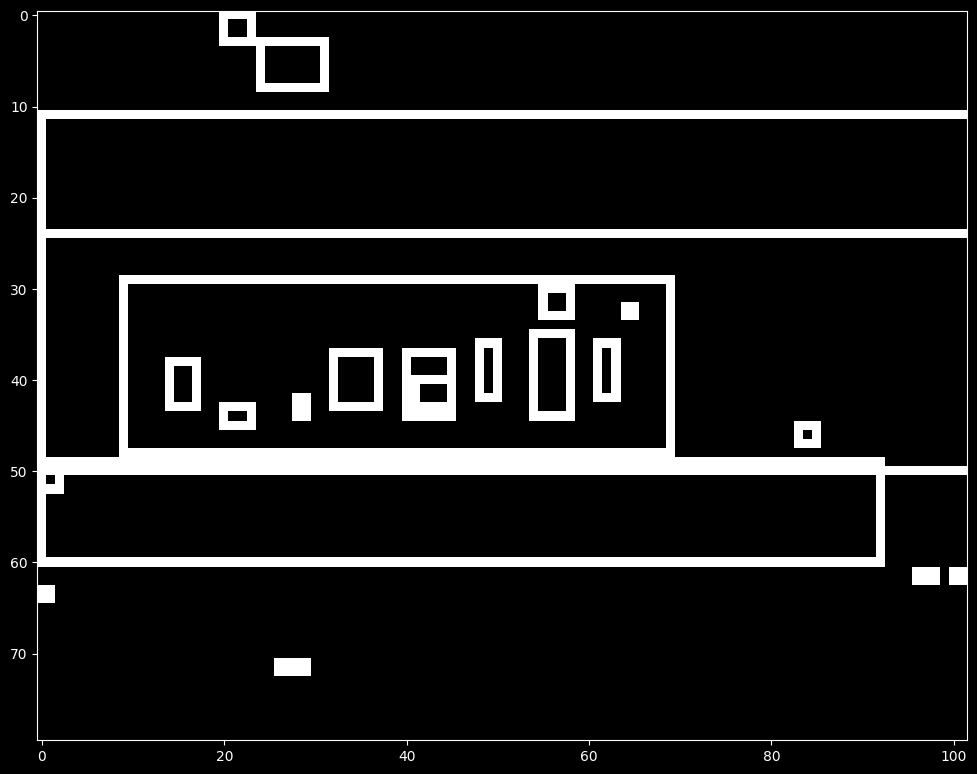

In [108]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=1)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
    
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

## # Select candidate by Char Size
---
- 번호판의 숫자들은 일정한 비율을 가진다
- 번호판 Contours의 width와 height의 비율은 모두 동일하거나 비슷하다
- 번호판 Contours 사이의 간격은 일정하다
- 최소 3개 이상 contours가 인접해 있어야 한다

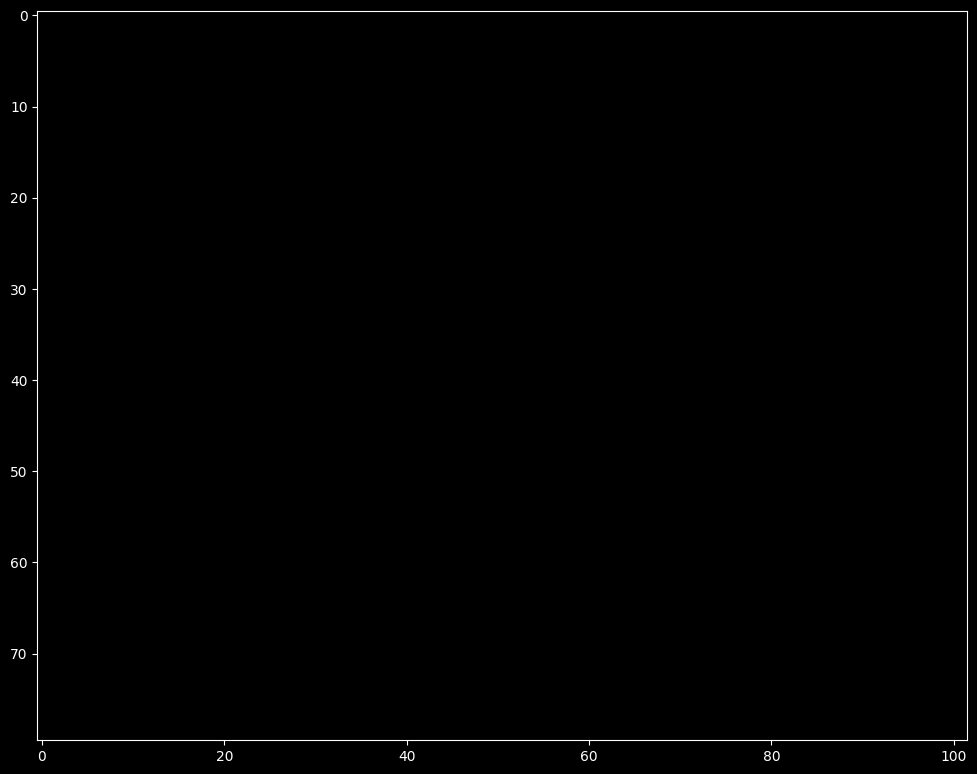

In [109]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT=2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

# temp_result = np.zeros((height, width, channel), dtype = np.uint8)

# for d in possible_contours:
#     cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)
    
# plt.figure(figsize=(12, 10))
# plt.imshow(temp_result, cmap='gray')

MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):

    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## # make carplate bbox
---

209 262 3


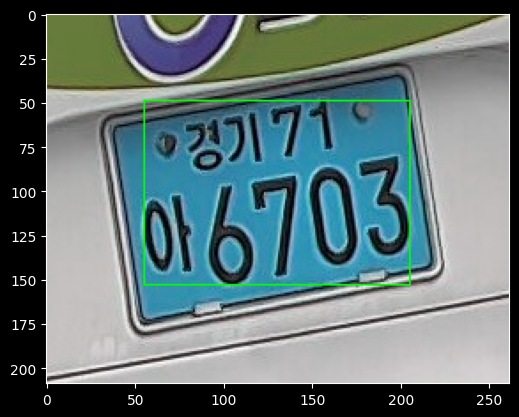

In [92]:
x = []
y = []
for r in matched_result:
    for d in r:
        x.append(int(d['x']))
        x.append(int(d['x']+d['w']))
        y.append(int(d['y']))
        y.append(int(d['y']+d['h']))

img_ori = cv2.imread('/data/kimgh/kakao/data/carplate/경기71아6703-25.jpg')
# img_ori = cv2.imread('/data/kimgh/kakao/data/carplate/01가1134-3.jpg')

height, width, channel = img_ori.shape

cv2.rectangle(img_ori, pt1=(min(x), min(y)), pt2=(max(x), max(y)), color=(0,255,0), thickness=1)

# plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')
print(height, width, channel)

(39, 36, 178, 138)
(37, 34, 183, 142)
(0, 17, 262, 166)


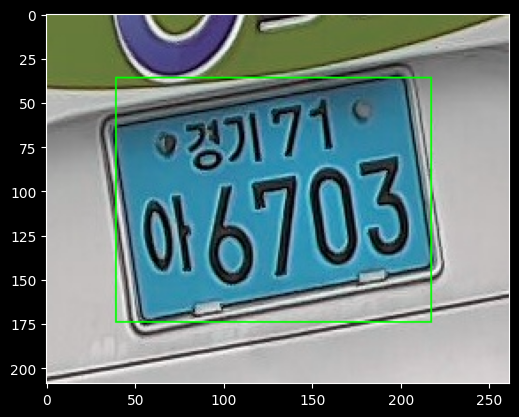

In [95]:
boxes = []
for contour in contours_dict:
    box = cv2.boundingRect(contour['contour'])
    # print(box)
    if box[0] < min(x) and box[1] < min(y) and box[2] > max(x)-min(x) and box[3] > max(y)-min(y):
        boxes.append(box)
        print(box)

x1, y1, w, h = max(boxes)

img_ori = cv2.imread('/data/kimgh/kakao/data/carplate/경기71아6703-25.jpg')
# img_ori = cv2.imread('/data/kimgh/kakao/data/carplate/01가1134-3.jpg')

height, width, channel = img_ori.shape

cv2.rectangle(img_ori, pt1=(x1, y1), pt2=(x1+w, y1+h), color=(0,255,0), thickness=1)

# plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')

# # Crop carplate (all processing)
---

In [3]:
def crop_carplate(img):
    import cv2
    import numpy as np

    # load image
    img_ori = cv2.imread(img)
    height, width, channel = img_ori.shape

    # convert to gray
    gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

    # thresholding and blur
    img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
    img_blur_thresh = cv2.adaptiveThreshold(img_blurred,
                                            maxValue=255.0,
                                            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            thresholdType=cv2.THRESH_BINARY_INV,
                                            blockSize=19,
                                            C=9)

    # find contours
    contours, _ = cv2.findContours(img_blur_thresh,\
                                   mode=cv2.RETR_LIST,
                                   method=cv2.CHAIN_APPROX_SIMPLE)
    
    contours_dict = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)        
        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
            })
    
    # select candidate by char size
    MIN_AREA = 80
    MIN_WIDTH, MIN_HEIGHT=2, 8
    MIN_RATIO, MAX_RATIO = 0.25, 1.0

    possible_contours = []
    cnt = 0
    for d in contours_dict:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']
        
        if area > MIN_AREA \
        and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            d['idx'] = cnt
            cnt += 1
            possible_contours.append(d)

    def find_chars(contour_list):
        MAX_DIAG_MULTIPLYER = 5
        MAX_ANGLE_DIFF = 12.0
        MAX_AREA_DIFF = 0.5
        MAX_WIDTH_DIFF = 0.8
        MAX_HEIGHT_DIFF = 0.2
        MIN_N_MATCHED = 3

        matched_result_idx = []
        for d1 in contour_list:
            matched_contours_idx = []
            for d2 in contour_list:
                if d1['idx'] == d2['idx']:
                    continue
                    
                dx = abs(d1['cx'] - d2['cx'])
                dy = abs(d1['cy'] - d2['cy'])
                
                diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
                
                distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
                if dx == 0:
                    angle_diff = 90
                else:
                    angle_diff = np.degrees(np.arctan(dy / dx))
                area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
                width_diff = abs(d1['w'] - d2['w']) / d1['w']
                height_diff = abs(d1['h'] - d2['h']) / d1['h']
                
                if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
                and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
                and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                    matched_contours_idx.append(d2['idx'])
                    
            matched_contours_idx.append(d1['idx'])
            
            if len(matched_contours_idx) < MIN_N_MATCHED:
                continue
                
            matched_result_idx.append(matched_contours_idx)
            
            unmatched_contour_idx = []
            for d4 in contour_list:
                if d4['idx'] not in matched_contours_idx:
                    unmatched_contour_idx.append(d4['idx'])

            unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
            
            recursive_contour_list = find_chars(unmatched_contour)
            
            for idx in recursive_contour_list:
                matched_result_idx.append(idx)
                
            break
            
        return matched_result_idx
    
    result_idx = find_chars(possible_contours)
    matched_result = []
    for idx_list in result_idx:
        matched_result.append(np.take(possible_contours, idx_list))

    # make carplate bbox
    char_x = []
    char_y = []
    for r in matched_result:
        for d in r:
            char_x.append(int(d['x']))
            char_x.append(int(d['x']+d['w']))
            char_y.append(int(d['y']))
            char_y.append(int(d['y']+d['h']))

    boxes = []
    for contour in contours_dict:
        box = cv2.boundingRect(contour['contour'])
        if box[0] < min(char_x) and box[1] < min(char_y) and box[2] > max(char_x)-min(char_x) and box[3] > max(char_y)-min(char_y):
            boxes.append(box)

    x1, y1, w, h = max(boxes)
    x2 = x1 + w
    y2 = y1 + h

    return x1, y1, x2, y2

In [2]:
x1, y1, x2, y2 = crop_carplate('/data/kimgh/kakao/data/carplate/01가0785.jpg')

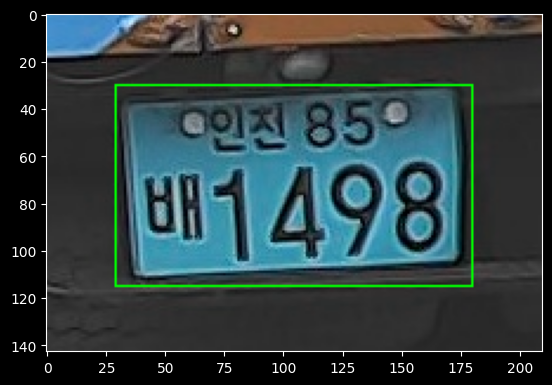

In [9]:
img = '/data/kimgh/kakao/data/carplate/인천85배1498-18.jpg'

img_ori = cv2.imread(img)
x1, y1, x2, y2 = crop_carplate(img)

height, width, channel = img_ori.shape

cv2.rectangle(img_ori, pt1=(x1, y1), pt2=(x2, y2), color=(0,255,0), thickness=1)

# plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')

# # make labels
---

In [1]:
src = '/data/kimgh/kakao/data/carplate/'
dst = '/data/kimgh/kakao/data/labels/'
os.makedirs(dst, exist_ok=True)

images = sorted(os.listdir(src))

NameError: name 'os' is not defined

In [5]:
src = '/data/kimgh/kakao/data/carplate/'
dst = '/data/kimgh/kakao/data/labels/'
os.makedirs(dst, exist_ok=True)

images = sorted(os.listdir(src))

def xyxy2xywhn(x, w=1920, h=1200, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    if clip:
        clip_boxes(x, (h - eps, w - eps))  # warning: inplace clip
    x = np.asarray(x, dtype=float).reshape(1, -1)
    y = np.copy(x)
    
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    y = list(y.reshape(-1))
    return y


non_search = []
for image in images:
    try:
        img = cv2.imread(src+'/'+image)
        h, w, c = img.shape

        x1, y1, x2, y2 = crop_carplate(src+'/'+images[0])
        xywhn = xyxy2xywhn([x1, y1, x2, y2], w=w, h=h)

        with open(dst+'/'+image[:-4]+'.txt', 'w') as f:
            f.write(' '.join(map(str, [0]+xywhn)))
    except:
        non_search.append(image[:-4])
        print(image[:-4])

In [6]:
non_search

[]